In [1]:
import os, sys, json, shutil, subprocess
import multiprocessing
import pickle

from metrics import *
from combination import *
from combination_with_estimation import *

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter, MultipleLocator

from model_basic import *
from model_realtime import *

%matplotlib inline

In [2]:
# Supplementary function for clearing a subset of cache
def clear_cache(dataset_dir, cache_prefix):
    cache_dir = os.path.join(dataset_dir, 'cache')
    if not os.path.exists(cache_dir):
        return
    subdirs = [os.path.join(cache_dir, x) for x in sorted(os.listdir(cache_dir))]
    for subdir in subdirs:
        files = sorted(os.listdir(subdir))
        for filename in files:
            if filename.startswith(cache_prefix):
                os.remove(os.path.join(subdir, filename))

Total: 691 clips


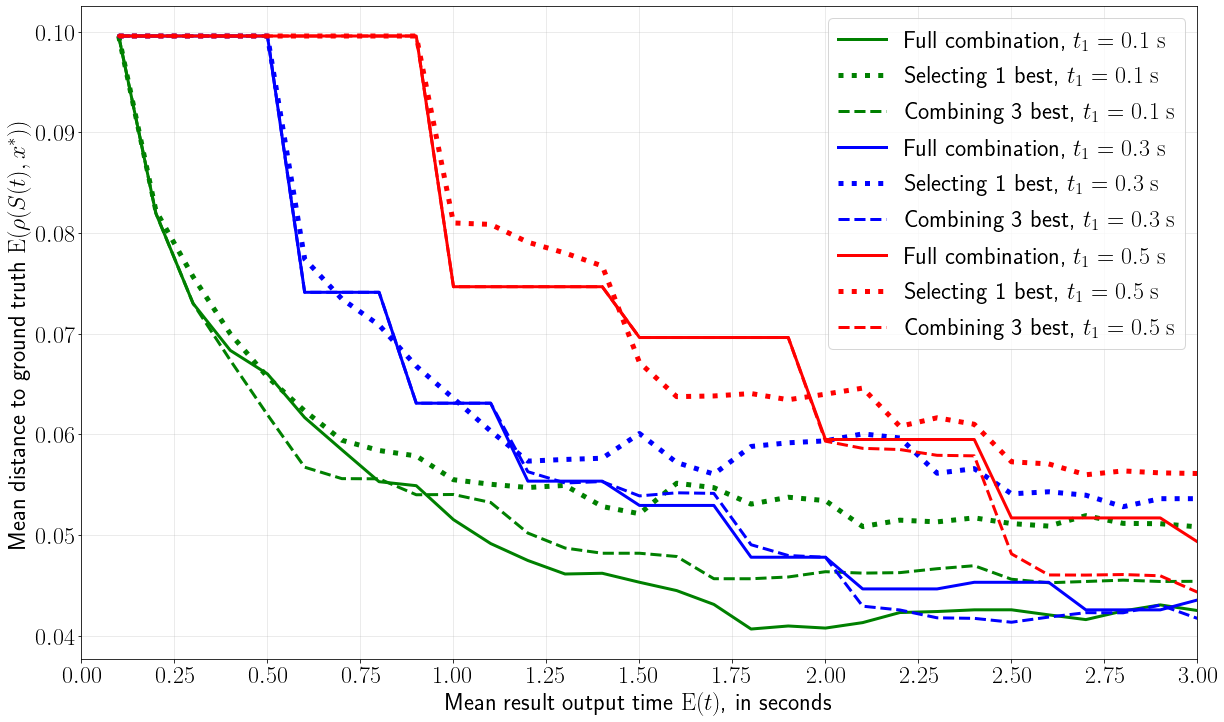

In [3]:
# Parsing dataset, recalculating modelling (or parsing cache), and constructing combination plots

dataset_dir = './midv500_ocr'
focus_file = './midv500_focus.json'

if not os.path.exists(os.path.join(dataset_dir, 'cache')):
    os.mkdir(os.path.join(dataset_dir, 'cache'))

focus_data = None
with open(focus_file) as js:
    focus_data = json.load(js)

clip_length = 30

dataset_gt_file = os.path.join(dataset_dir, 'gt.json')
dataset_gt = None
with open(dataset_gt_file) as js:
    dataset_gt = json.load(js)

full_skips = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
full_colors = ['green', 'red', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'lime', 'crimson', 'olive']

fig2_skips = [1, 3, 5]
fig2_colors = ['green', 'blue', 'red']

ngld_plot = {
    'full_comb': [[0.0] * clip_length for skip in full_skips],
    '1_best': [[0.0] * clip_length for skip in full_skips],
    '3_best': [[0.0] * clip_length for skip in full_skips]
}

ngld_plot_linestyle = {
    'full_comb': '-',
    '1_best': ':',
    '3_best': '--'
}

ngld_plot_linewidth = {
    'full_comb': 3,
    '1_best': 5,
    '3_best': 3
}

ngld_plot_legend = {
    'full_comb': 'Full combination',
    '1_best': 'Selecting 1 best',
    '3_best': 'Combining 3 best'
}

clipmodel = {
    'full_comb': clipmodel_full_combination,
    '1_best': clipmodel_1_best,
    '3_best': clipmodel_3_best
}

realtime_events = {
    'full_comb': [[] for skip in full_skips],
    '1_best': [[] for skip in full_skips],
    '3_best': [[] for skip in full_skips]
}

rtmodel = {
    'full_comb': rtmodel_full_combination,
    '1_best': rtmodel_1_best,
    '3_best': rtmodel_3_best
}

num_clips = 0

for i_clip, clip in enumerate(list(dataset_gt.keys())):
    cache_dir = os.path.join(dataset_dir, 'cache', '%s' % clip)
    if not os.path.exists(cache_dir):
        os.mkdir(cache_dir)
    
    rec_file = os.path.join(dataset_dir, '%s.pkl' % clip)
    rec_clip = None
    with open(rec_file, 'rb') as ps:
        rec_clip = pickle.load(ps)
    
    rec_clip = [convert_ocrstring(x) for x in rec_clip]
    foc_clip = focus_data[clip.split('_')[1]]
    
    for method in ngld_plot.keys():
        ngld = [None for skip in full_skips]
        for s, skip in enumerate(full_skips):
            ngld[s] = clipmodel[method](rec_clip, foc_clip, skip, dataset_gt[clip], cache_dir)
        for s, skip in enumerate(full_skips):
            for i in range(clip_length):
                ngld_plot[method][s][i] += ngld[s][i]

    for method in realtime_events.keys():
        for s, skip in enumerate(full_skips):
            clip_events = rtmodel[method](rec_clip, foc_clip, skip, dataset_gt[clip], cache_dir)
            realtime_events[method][s].extend([(delta, ngld, time, num_clips) for (delta, ngld, time) in clip_events])
        
    num_clips += 1

for method in ngld_plot.keys():
    for s, skip in enumerate(full_skips):
        for i in range(clip_length):
            ngld_plot[method][s][i] /= num_clips
        first_nonone = None
        for i in range(clip_length):
            if ngld_plot[method][s][i] < 1.0:
                first_nonone = ngld_plot[method][s][i]
                break
        for i in range(clip_length):
            if ngld_plot[method][s][i] < 1.0:
                break
            ngld_plot[method][s][i] = first_nonone
        
x = [(i + 1.0)* 0.1 for i in range(clip_length)]
baseline_x = x
    
plt.rcParams['figure.figsize'] = (20, 12)
plt.rcParams.update({'font.size': 24})
plt.rcParams.update({'text.usetex': True})
plt.rcParams.update({'text.latex.preamble': r'\usepackage{amsmath} \DeclareMathOperator{\E}{E}'})
plt.rcParams.update({'pdf.fonttype': 42})

plt.xlabel(r'Mean result output time $\E(t)$, in seconds')
plt.ylabel(r'Mean distance to ground truth $\E(\rho(S(t), x^*))$')
plt.xlim([0, clip_length * 0.1])
plt.gca().yaxis.set_major_locator(MultipleLocator(0.01))
plt.xticks([0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0])
plt.grid(which = 'major', alpha = 0.3)

for s, skip in enumerate(fig2_skips):
    for method in ngld_plot.keys():
        plt.plot(x, ngld_plot[method][skip - 1], \
                 label='%s,~$t_1=%.1f~\\mathrm{s}$' % (ngld_plot_legend[method], skip * 0.1), \
                 color=fig2_colors[s], \
                 linestyle=ngld_plot_linestyle[method], \
                 linewidth=ngld_plot_linewidth[method])
        
plt.legend()
plt.savefig('fig_2.pdf', dpi=1200, bbox_inches='tight', pad_inches=0.05)

print('Total: %d clips' % num_clips)

In [4]:
# Constructs expected performance profiles based on a list of modelling events

def build_epp(events):
    sorted_events = sorted(events, reverse=True)
    
    current_ngld_per_clip = [None for i in range(num_clips)]
    current_time_per_clip = [None for i in range(num_clips)]

    # starting point

    current_ngld_sum = 0.0
    current_time_sum = 0.0

    for i in range(num_clips):
        delta, ngld, time, i_clip = sorted_events[i]
        current_ngld_per_clip[i_clip] = ngld
        current_time_per_clip[i_clip] = time

        current_ngld_sum += ngld
        current_time_sum += time

    if None in current_ngld_per_clip:
        raise Exception('ERRROR: none-value in current_ngld_per_clip starting point')
    if None in current_time_per_clip:
        raise Exception('ERRROR: none-value in current_time_per_clip starting point')

    epp_time = [current_time_sum / num_clips]
    epp_ngld = [current_ngld_sum / num_clips]
    epp_delta = [0.0]

    for i in range(num_clips, len(sorted_events)):
        delta, ngld, time, i_clip = sorted_events[i]

        current_ngld_sum -= current_ngld_per_clip[i_clip]
        current_time_sum -= current_time_per_clip[i_clip]

        current_ngld_per_clip[i_clip] = ngld
        current_time_per_clip[i_clip] = time

        current_ngld_sum += ngld
        current_time_sum += time

        if (i + 1 == len(sorted_events)) or (sorted_events[i + 1][0] < delta): # if this the last of the current delta value
            epp_time.append(current_time_sum / num_clips)
            epp_ngld.append(current_ngld_sum / num_clips)
            epp_delta.append(delta)
    
    return epp_time, epp_ngld, epp_delta

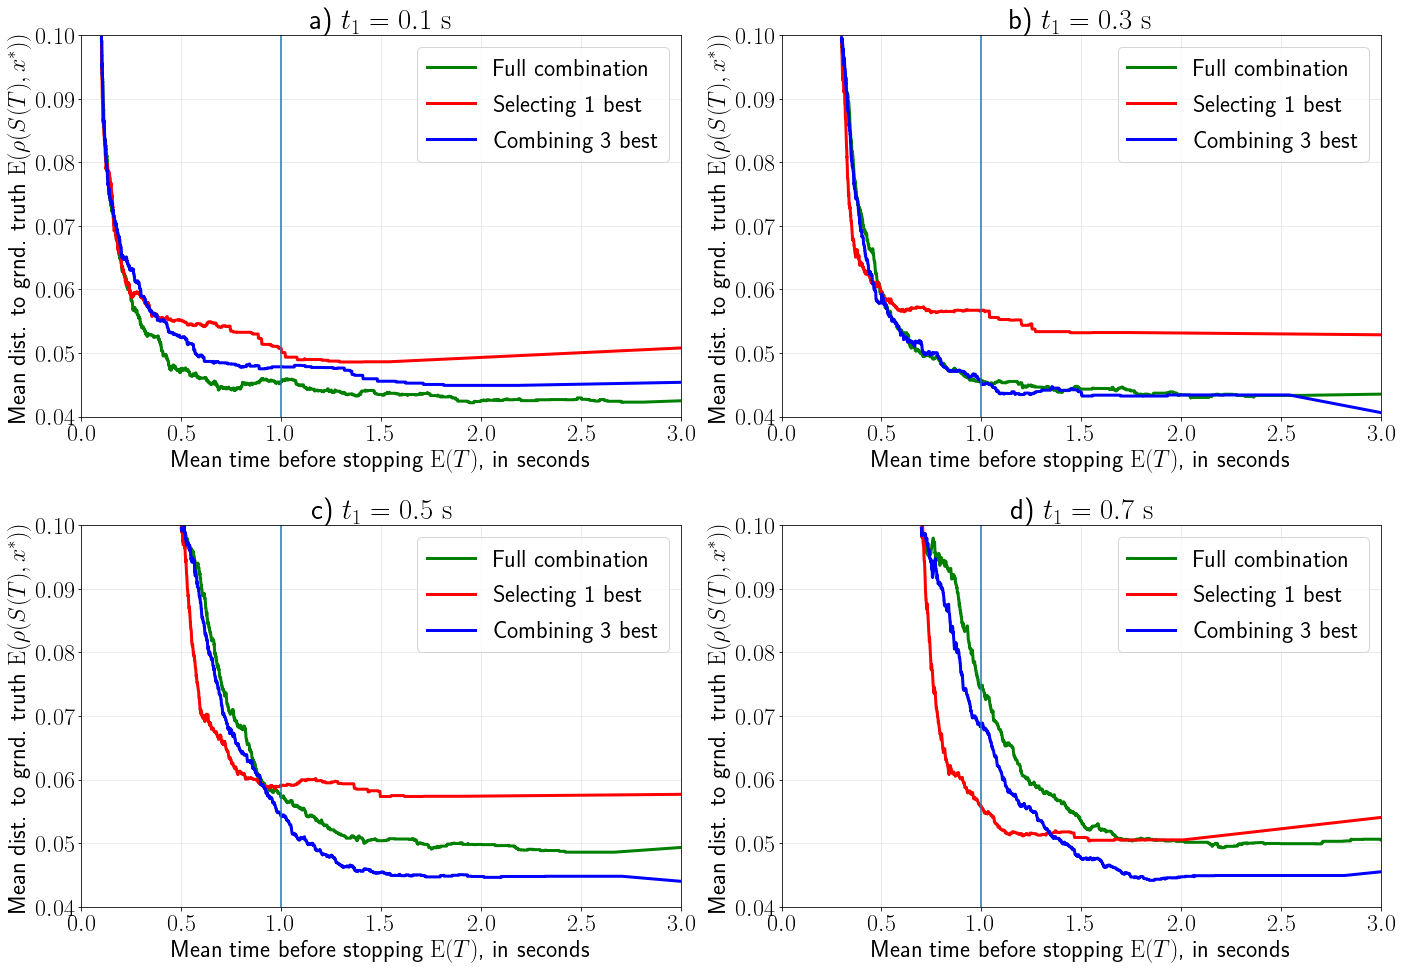

In [5]:
# Constructing expected performance profiles

realtime_epp = {
    'full_comb': [([], []) for skip in full_skips],
    '1_best': [([], []) for skip in full_skips],
    '3_best': [([], []) for skip in full_skips]
}

realtime_epp_color_linestyle = {
    'full_comb': ('green', '-'),
    '1_best': ('red', '-'),
    '3_best': ('blue', '-')
}

realtime_epp_legend = {
    'full_comb': 'Full combination',
    '1_best': 'Selecting 1 best',
    '3_best': 'Combining 3 best'
}

for method in realtime_epp.keys():
    for s, skip in enumerate(full_skips):
        realtime_epp[method][s] = build_epp(realtime_events[method][s])

plt.rcParams['figure.figsize'] = (20, 14)
plt.rcParams.update({'font.size': 24})
plt.rcParams.update({'text.usetex': True})
plt.rcParams.update({'text.latex.preamble': r'\usepackage{amsmath} \DeclareMathOperator{\E}{E}'})
plt.rcParams.update({'pdf.fonttype': 42})

subplot_types = [221, 222, 223, 224]
subplot_s_indices = [0, 2, 4, 6]
subplot_title_letters = 'abcd'

for subplot_type, subplot_s_index, subplot_title_letter in zip(subplot_types, subplot_s_indices, subplot_title_letters):
    plt.subplot(subplot_type)
    skip = full_skips[subplot_s_index]
    for method in realtime_epp.keys():
        plt.plot([x * 0.1 for x in realtime_epp[method][subplot_s_index][0]], realtime_epp[method][subplot_s_index][1], \
                 label='%s' % (realtime_epp_legend[method],),\
                 color=realtime_epp_color_linestyle[method][0],\
                 linestyle=realtime_epp_color_linestyle[method][1],\
                 linewidth=3)
    plt.axvline(x=1.0)
    plt.gca().yaxis.set_major_locator(MultipleLocator(0.01))
    plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
    plt.grid(which = 'major', alpha = 0.3)
    plt.legend()
    plt.ylim([0.04, 0.1])
    plt.xlim([0, clip_length * 0.1])
    plt.title('%s) $t_1=%.1f~\\mathrm{s}$' % (subplot_title_letter, skip * 0.1))
    plt.xlabel(r'Mean time before stopping $\E(T)$, in seconds')
    plt.ylabel(r'Mean dist. to grnd. truth $\E(\rho(S(T), x^*))$')

plt.tight_layout(w_pad=0.5, h_pad=1)
plt.savefig('fig_3.pdf', dpi=1200, bbox_inches='tight', pad_inches=0.05)

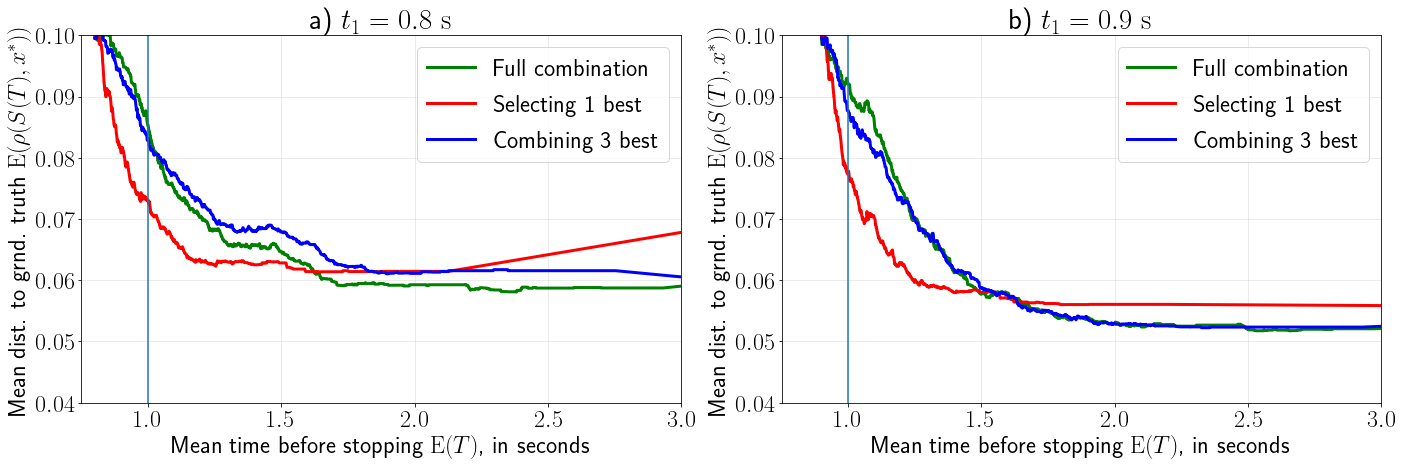

In [6]:
# Constructing expected performance profiles (continuation)

plt.rcParams['figure.figsize'] = (20, 7)
plt.rcParams.update({'font.size': 24})
plt.rcParams.update({'text.usetex': True})
plt.rcParams.update({'text.latex.preamble': r'\usepackage{amsmath} \DeclareMathOperator{\E}{E}'})
plt.rcParams.update({'pdf.fonttype': 42})

subplot_types = [121, 122]
subplot_s_indices = [7, 8]
subplot_title_letters = 'abcd'

for subplot_type, subplot_s_index, subplot_title_letter in zip(subplot_types, subplot_s_indices, subplot_title_letters):
    plt.subplot(subplot_type)
    skip = full_skips[subplot_s_index]
    for method in realtime_epp.keys():
        plt.plot([x * 0.1 for x in realtime_epp[method][subplot_s_index][0]], realtime_epp[method][subplot_s_index][1], \
                 label='%s' % (realtime_epp_legend[method],),\
                 color=realtime_epp_color_linestyle[method][0],\
                 linestyle=realtime_epp_color_linestyle[method][1],\
                 linewidth=3)
    plt.axvline(x=1.0)
    plt.gca().yaxis.set_major_locator(MultipleLocator(0.01))
    plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
    plt.grid(which = 'major', alpha = 0.3)
    plt.legend()
    plt.ylim([0.04, 0.1])
    plt.xlim([0.75, clip_length * 0.1])
    plt.title('%s) $t_1=%.1f~\\mathrm{s}$' % (subplot_title_letter, skip * 0.1))
    plt.xlabel(r'Mean time before stopping $\E(T)$, in seconds')
    plt.ylabel(r'Mean dist. to grnd. truth $\E(\rho(S(T), x^*))$')

plt.tight_layout(w_pad=0.5, h_pad=1)
plt.savefig('fig_4.pdf', dpi=1200, bbox_inches='tight', pad_inches=0.05)

In [7]:
# Constructing comparison table

def find_closest_point(epp, target_x):
    best_dist = 1e100
    best_i = 0
    for i in range(len(epp[0])):
        if abs(epp[0][i] - target_x) < best_dist:
            best_dist = abs(epp[0][i] - target_x)
            best_i = i
    return epp[0][best_i], epp[1][best_i], epp[2][best_i]

print('Table 2')
print('t_1    full comb    1 best    3 best')
for s in range(10):
    skip = full_skips[s]
    ys = {}
    for method in realtime_epp.keys():
        x, ys[method], delta = find_closest_point(realtime_epp[method][s], 10)
#         print('t_1 = %.1f s. %s: (%lf, %lf). Delta = %lf' % (skip * 0.1, method, x, ys[method], delta))
    print('%.1f s.   %.3lf      %.3lf     %.3lf' % (skip * 0.1, ys['full_comb'], ys['1_best'], ys['3_best']))

Table 2
t_1    full comb    1 best    3 best
0.1 s.   0.046      0.051     0.048
0.2 s.   0.044      0.052     0.041
0.3 s.   0.046      0.057     0.045
0.4 s.   0.056      0.054     0.053
0.5 s.   0.057      0.059     0.054
0.6 s.   0.056      0.056     0.054
0.7 s.   0.075      0.056     0.069
0.8 s.   0.085      0.073     0.083
0.9 s.   0.092      0.077     0.088
1.0 s.   0.100      0.100     0.100
